from https://docs.predibase.com/user-guide/getting-started/end-to-end

A CPU instance would be sufficient!

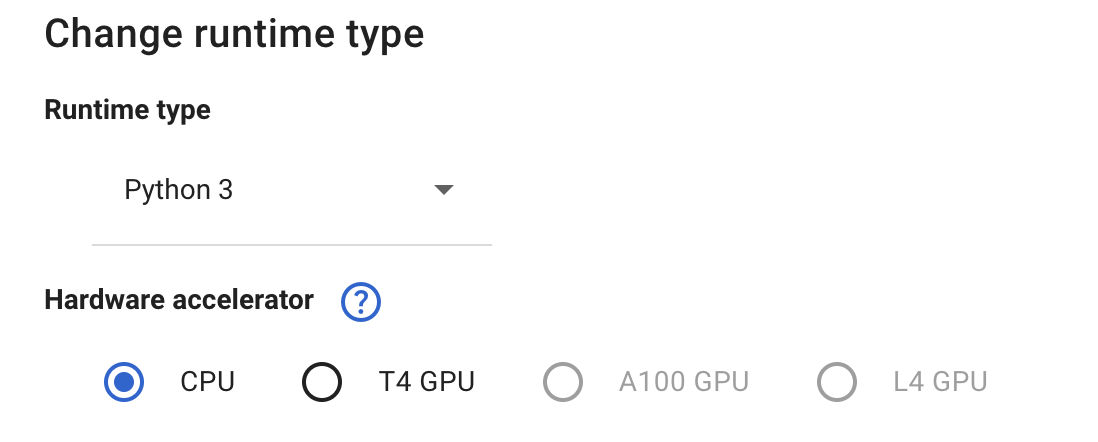


In [ ]:
!pip install -q predibase datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from predibase import Predibase, FinetuningConfig, DeploymentConfig

# Get a KEY from https://app.predibase.com/
from google.colab import userdata
api_token: str = userdata.get('Predibase')
pb = Predibase(api_token=api_token)

Connected to Predibase as User(id=e8120734-03a0-4726-be6a-ee52c67041a3, username=jonathansiew.2004@gmail.com)

## API KEY
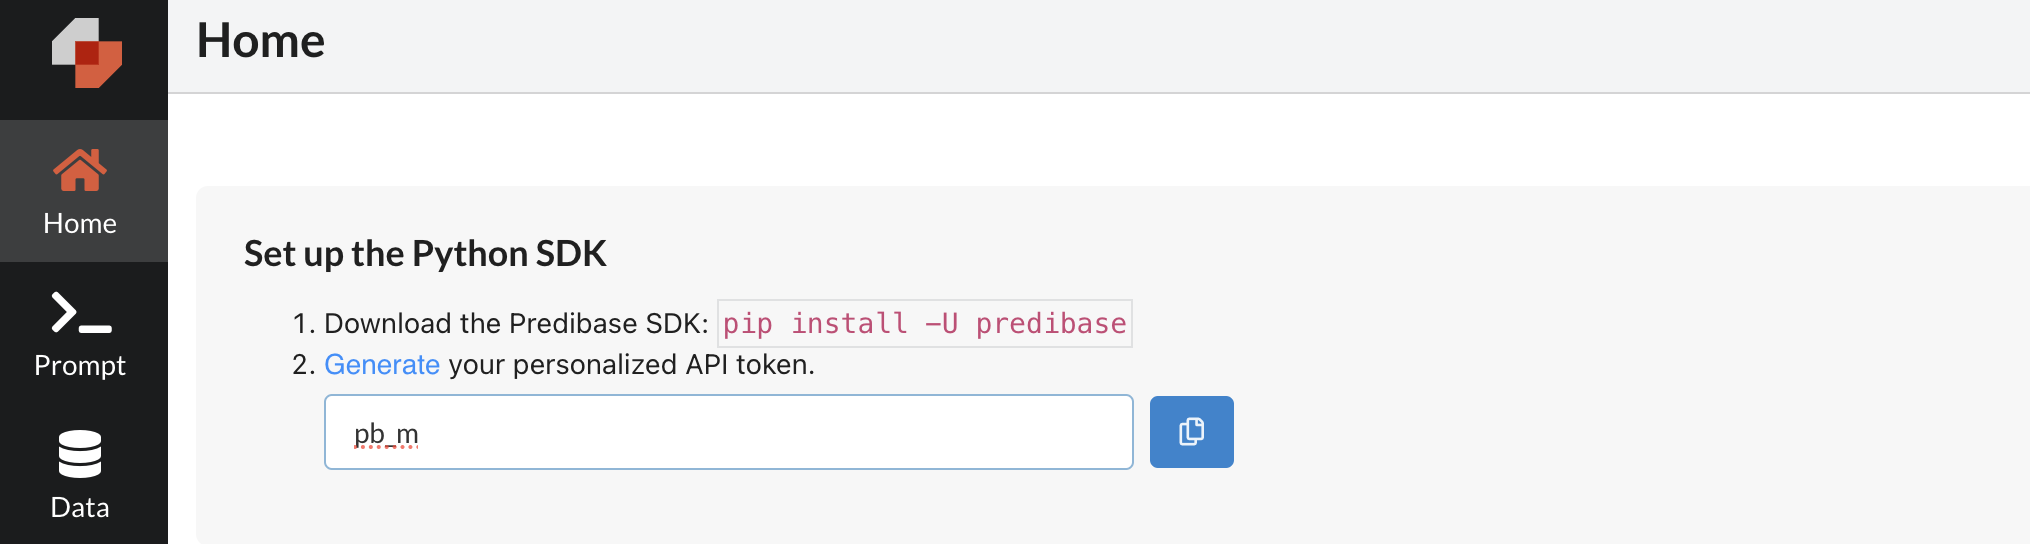

## Overall Process
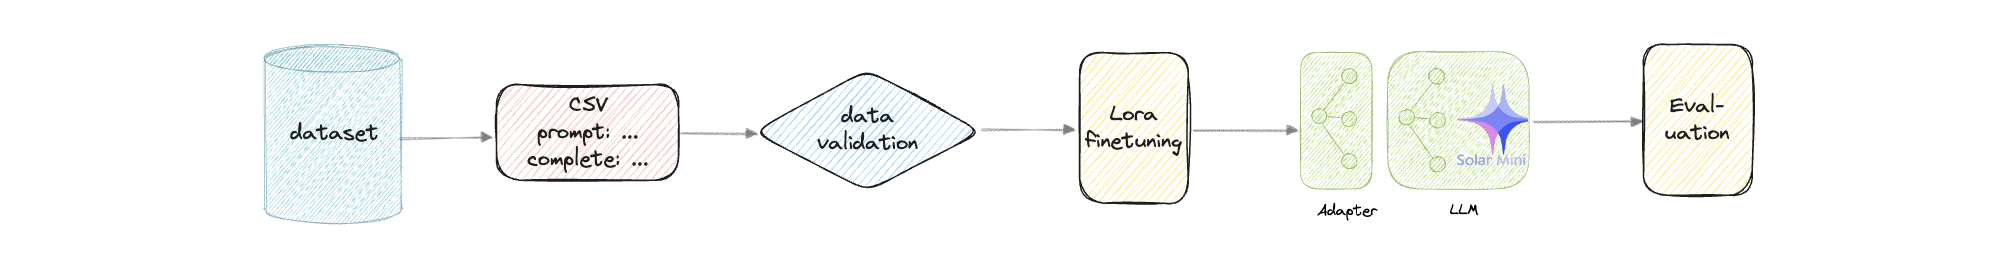

## Process the dataset
### Original
headline (string), content (strong), category

### Tobe
```
prompt:

<s>[INST] The following passage is content from a news report. Please summarize this passage in one sentence or less.

Passage: {content}.

Summary:
 [/INST]
---
 completion:
 {headline}

 ---
 split: train/test
 ```

In [ ]:
dataset = pb.datasets.from_file("/content/Updated Uncle Roger Upstage Jeju Tourism FAQs.csv", name="August 2024 Updated Uncle Roger Jeju Tourism FAQ")

ServerResponseError: Error 400: uploaded dataset with name already exists: August 2024 Updated Uncle Roger Jeju Tourism FAQ. Trace ID: 37e9fad9d850c0c4e057f8dd49df7108

In [ ]:
import pandas as pd
import json

# Load the dataset
file_path = "/content/Updated Uncle Roger Upstage Jeju Tourism FAQs.csv"
data = pd.read_csv(file_path)

# Select only the necessary columns and rename them
data = data[['Prompt', 'Completion']]
data.columns = ['Prompt', 'Completion']

# Correctly format each entry as a JSON string with double quotes
jsonl_data = [
    json.dumps({"prompt": row["Prompt"], "completion": row["Completion"]})
    for index, row in data.iterrows()
]

# Save the JSONL data to a file
jsonl_path = '/content/Updated Uncle Roger Jeju Island Tourism FAQ.jsonl'
with open(jsonl_path, 'w') as f:
    for entry in jsonl_data:
        f.write(entry + "\n")

jsonl_path

'/content/Updated Uncle Roger Jeju Island Tourism FAQ.jsonl'

In [ ]:
import json

# Function to validate and display the first few JSONL entries
def check_jsonl(file_path, num_lines=5):
    with open(file_path, 'r') as file:
        for i in range(num_lines):
            line = file.readline()
            try:
                print(json.loads(line))  # Try to parse JSON
            except json.JSONDecodeError as e:
                print(f"Error in line {i+1}: {e}")

# Call the function to check the file
check_jsonl(jsonl_path)

{'prompt': 'size of jeju island how big', 'completion': 'Jeju Island? Big place, ah! Got about 1,849 square kilometers. That’s 714 square miles. Big enough to explore lots, but still find your way home for dinner, very nice!'}
{'prompt': 'jeju weather what like', 'completion': 'Oh, Jeju weather good for chilling! Summers warm, around 25-30°C, just right for beach. Winters mild, like 5-10°C, no need for big coat. Rain also likes to visit, especially in August and September, so keep umbrella handy!'}
{'prompt': 'highest point jeju where', 'completion': "Highest spot? That's Hallasan Mountain, lah! Reaches up 1,950 meters, taller than any skyscraper in Korea. Climb up and the view will knock your socks off!"}
{'prompt': 'jeju famous for what', 'completion': 'Jeju famous for many things. Got UNESCO spots like volcanic landscapes, beautiful Hallasan, and cool lava tubes. Plus, culture rich and traditions unique, very special!'}
{'prompt': 'unesco sites in jeju what are they', 'completion': 

In [ ]:
from tokenizers import Tokenizer
import json

tokenizer = Tokenizer.from_pretrained("upstage/solar-1-mini-tokenizer")

def compute_cost(jsonl_file_name, price_per_million_tokens=0.5):
    """ Compute the cost of the dataset based on token count from a JSONL file """
    total_num_of_tokens = 0

    with open(jsonl_file_name, 'r') as file:
        for line in file:
            data = json.loads(line)  # Load each JSONL line as a dictionary
            combined_text = data['completion'] + " " + data['prompt']  # Combine 'completion' and 'prompt'
            enc = tokenizer.encode(combined_text)
            total_num_of_tokens += len(enc.tokens)  # Sum the number of tokens

    # Calculate the cost based on tokens
    return total_num_of_tokens / 1000000 * price_per_million_tokens

# Usage
jsonl_file_path = '/content/Updated Uncle Roger Jeju Island Tourism FAQ.jsonl'  # Update this path to the location of your JSONL file
cost = compute_cost(jsonl_file_path)
print(f"Total cost: USD${cost}")

tokenizer.json:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

Total cost: USD$0.0025695


In [ ]:
dataset = pb.datasets.from_file("/content/Updated Uncle Roger Jeju Island Tourism FAQ.jsonl", name="august2024_updated_uncle_roger_jsonl_jeju_faq")

ServerResponseError: Error 400: uploaded dataset with name already exists: august2024_updated_uncle_roger_jsonl_jeju_faq. Trace ID: 04b0424c3204152d35832cf2a740a2f0

In [ ]:
dataset_name = "august2024_updated_uncle_roger_jsonl_jeju_faq"
pb_dataset = pb.datasets.get(dataset_name)
print(f"Dataset found: {pb_dataset}")

Dataset found: uuid='d55b6d4d-b85c-4348-a98a-14b24bd23dca' name='august2024_updated_uncle_roger_jsonl_jeju_faq' connection_type='file' connection_name='file_uploads' status='connected'


## Create Adapter

In [ ]:
# Create an adapter repository
repo_name = "August 2024 UncleRogerAINewbiesTourismGPT"
repo = pb.repos.create(name=repo_name, description="August 2024 Uncle Roger Jeju AI_Newbies Tourism GPT", exists_ok=True)
print(repo)

uuid='fb6dcb6e-21a3-41f0-bdfe-8f50480fdad3' name='August 2024 UncleRogerAINewbiesTourismGPT' description='August 2024 Uncle Roger Jeju AI_Newbies Tourism GPT'


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Without Adapter Train Method

def get_validation_loss(adapter):
    # Retrieve and return the validation loss for the adapter
    try:
        return adapter.metrics['validation_loss'][-1]
    except Exception as e:
        print(f"Error retrieving validation loss: {e}")
        return float('inf')

import optuna

def objective(trial):
    epochs = 10
    rank = 16

    try:
        # Create and train the adapter
        adapter = pb.adapters.create(
            config=FinetuningConfig(
                base_model="solar-1-mini-chat-240612",
                epochs=epochs,
                rank=rank,
            ),
            dataset=pb_dataset, # Also accepts the dataset name as a string
            repo=repo,
            description=f"tuning epochs={epochs}, rank={rank}"
        )

        # Extract the validation loss from the trained model
        validation_loss = get_validation_loss(adapter)
        print(f"Validation loss for params (epochs={epochs}, rank={rank}): {validation_loss}")

        return validation_loss

    except Exception as e:
        print(f"Error during training with params (epochs={epochs}, rank={rank}): {e}")
        return float('inf')

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"Best parameters: {study.best_params}")
print(f"Best validation loss: {study.best_value}")

[I 2024-08-12 03:48:20,266] A new study created in memory with name: no-name-dd5d5340-b9a2-493c-ac27-45f413429f0d


Successfully requested finetuning of solar-1-mini-chat-240612 as `August 2024 UncleRogerAINewbiesTourismGPT/25`. (Job UUID: 4b37d61d-4ed9-4e7e-b3f8-8260237ae536).

Watching progress of finetuning job 4b37d61d-4ed9-4e7e-b3f8-8260237ae536. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.


Job is queued for execution. Time in queue: 0:00:01

[W 2024-08-12 03:48:23,588] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-12-683014b699af>", line 19, in objective
    adapter = pb.adapters.create(
  File "/usr/local/lib/python3.10/dist-packages/predibase/resources/adapters.py", line 42, in create
    job = self._client.finetuning.jobs.create(
  File "/usr/local/lib/python3.10/dist-packages/predibase/resources/finetuning_jobs.py", line 68, in create
    return self.watch(job) if watch else job
  File "/usr/local/lib/python3.10/dist-packages/predibase/resources/finetuning_jobs.py", line 88, in watch
    job_resp = self._client.http_get(f"/v2/finetuning/jobs/{job_ref}")
  File "/usr/local/lib/python3.10/dist-packages/predibase/_client.py", line 147, in http_get
    return _to_json(do())
  File "<decorator-

KeyboardInterrupt: 

| Feature                   | Grid Search                            | Optuna                                    |
|---------------------------|----------------------------------------|-------------------------------------------|
| Ease of Implementation    | Simple                                 | More complex                              |
| Computation Time          | High                                    | Lower, more efficient                     |
| Parameter Space Handling  | Exhaustive but limited                 | Efficient and flexible                    |
| Scalability               | Poor for large spaces                  | Good for large spaces                     |
| Reproducibility           | High (deterministic)                   | Medium (stochastic, but can set seed)     |
| Advanced Features         | None                                   | Early stopping, conditional parameters    |

In [ ]:
print(dir(adapter))

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_args__', '__repr_name__', '__repr_str__', '__rich_r

In [ ]:
# Get detailed help
help(adapter)

Help on Adapter in module predibase.resources.adapter object:

class Adapter(pydantic.main.BaseModel)
 |  Adapter(*, repo: str, tag: typing.Annotated[int, Gt(gt=0)], archived: bool, baseModel: str, description: str | None = None, adapterPath: str | None = None, finetuning_error: str | None = None, finetuning_job_uuid: str | None = None) -> None
 |  
 |  Method resolution order:
 |      Adapter
 |      pydantic.main.BaseModel
 |      builtins.object
 |  
 |  Readonly properties defined here:
 |  
 |  name
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  __annotations__ = {'archived': 'bool', 'artifact_path': 'str | None', ...
 |  
 |  __class_vars__ = set()
 |  
 |  __pr

## Selecting the Best Adapter

In [ ]:
dir (pb.adapters)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_client',
 '_fetch',
 '_parse_id',
 '_session',
 'archive',
 'cancel',
 'create',
 'delete',
 'download',
 'get',
 'unarchive',
 'upload']

In [ ]:
adapter=pb.adapters.get("August 2024 UncleRogerAINewbiesTourismGPT/22")
adapter

Adapter(repo='UncleRogerAINewbiesTourismGPT', tag=2, archived=False, base_model='solar-1-mini-chat-240612', description='tuning epochs=10, rank=16', artifact_path='b09c518e-cd21-4b41-ab8f-e2996d8e38ab/ba229c94ae5a48bd9702ceda095c7146/artifacts/model/model_weights', finetuning_error=None, finetuning_job_uuid='b09c518e-cd21-4b41-ab8f-e2996d8e38ab')

In [ ]:
input_prompt="""
<|im_start|>user\n What is your name <|im_end|>\n<|im_start|>assistant\n
"""

In [ ]:
dir (adapter)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_validator__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__repr_a

In [ ]:
# Using base model

# Initialize the deployment client
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")

# Generate text using the specified adapter
generated_text = lorax_client.generate(input_prompt, max_new_tokens=1000).generated_text
print(generated_text)

My name is Open Assistant.


In [ ]:
# Using my adapter

# Initialize the deployment client
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")

# Generate text using the specified adapter
generated_text = lorax_client.generate(input_prompt, adapter_id="UncleRogerAINewbiesTourismGPT/2", max_new_tokens=1000).generated_text
print(generated_text)

My name is Open Assistant.


In [ ]:
# CURL test
import requests
import json

url = "https://serving.app.predibase.com/7ea6d0/deployments/v2/llms/solar-1-mini-chat-240612/generate"


payload = {
    "inputs": input_prompt,
    "parameters": {
        "adapter_id": "UncleRogerAINewbiesTourismGPT/2",
        "adapter_source": "pbase",
        "max_new_tokens": 20,
        "temperature": 0.1
    }
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_token}"
}

response = requests.post(url, data=json.dumps(payload), headers=headers)

aprint(response.text)

{"generated_text":"To spend economically in Korea, you can look for clearance items at discount stores, outlet"}


In [ ]:
adapter_id="UncleRogerAINewbiesTourismGPT/2"

# Download adapter
pb.adapters.download(adapter_id, dest=f"{adapter.tag}.zip")

Done!


In [ ]:
# Unzip
import zipfile
with zipfile.ZipFile(f"{adapter.tag}.zip", 'r') as zip_ref:
  zip_ref.extractall(f"adapter_{adapter.tag}")

# Upload Adapter
adapter2 = pb.adapters.upload(f"adapter_{adapter.tag}", repo_name, "solar-1-mini-chat-240612")
adapter2

Uploading adapter to repo UncleRogerAINewbiesTourismGPT...
Done!


Adapter(repo='UncleRogerAINewbiesTourismGPT', tag=3, archived=False, base_model='solar-1-mini-chat-240612', description=None, artifact_path='419fdf48-593f-4aef-99c1-fd953b171286/00000000000000000000000000000000/artifacts/model/model_weights', finetuning_error=None, finetuning_job_uuid=None)

In [ ]:
adapter2_id = adapter2.repo + "/" + str(adapter2.tag)
adapter2_id

NameError: name 'adapter2' is not defined

In [ ]:
lorax_client = pb.deployments.client("solar-1-mini-chat-240612")
print(lorax_client.generate(input_prompt, adapter_id=adapter2_id, max_new_tokens=1000).generated_text)

Upstage, a South Korean AI startup, secured 100 billion won ($72 million) from investors to expand in the US, Japan, and Southeast Asia.


In [ ]:
# FIXME: Can we fine-tune on the previous adaptor?

In [ ]:
!pip -q install langchain langchain-upstage solar-as-judge

In [ ]:
import os
from google.colab import userdata
import solar_as_judge as saj

os.environ["UPSTAGE_API_KEY"] = userdata.get('UPSTAGE_API_KEY')

prompt = "Please extract important keyword from this text: I love you so much"
ground_truth = "love"
A_answer = "love"
B_answer = "so much"

a_score, b_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
print(a_score, b_score)


10 2


In [ ]:
# Create test dataset
test_csv_file_name = f"test_dataset.csv"
hfdataset_to_csv(test_hfdataset, test_csv_file_name, max=20)

win_results = {"A_wins":0, "B_wins": 0, "tie": 0,  "A_score": 0, "B_score": 0}
with open(test_csv_file_name, 'r') as f:
  reader = csv.DictReader(f)
  for row in reader:
    prompt = row['prompt']
    ground_truth = row['completion']
    A_answer = lorax_client.generate(prompt, max_new_tokens=1000).generated_text
    B_answer = lorax_client.generate(prompt, adapter_id=adapter_id, max_new_tokens=1000).generated_text

    A_score, B_score = saj.judge(prompt, A_answer, B_answer, ground_truth)
    print( A_score, B_score, A_answer, B_answer)
    win_results["A_score"] += A_score
    win_results["B_score"] += B_score
    if A_score > B_score:
      win_results["A_wins"] += 1
    elif B_score > A_score:
      win_results["B_wins"] += 1
    else:
      win_results["tie"] += 1
    print(win_results)


0 0 Facebook released a report detailing the most widely viewed content by Americans between April and June, including top domains, links, pages, and posts, with a companion guide explaining data collection and analysis methods. Facebook released a report detailing the most widely viewed content by Americans between April and June, including top domains, links, pages, and posts.
{'A_wins': 0, 'B_wins': 0, 'tie': 1, 'A_score': 0, 'B_score': 0}
0 0 Researchers have demonstrated a proof-of-concept quantum battery using superabsorption, which could lead to faster charging for electric vehicles and improved energy storage systems. Researchers have demonstrated a quantum battery that charges faster with increasing size, using a quantum effect called superabsorption, which could lead to advancements in fast-charging electric vehicles and energy storage systems.
{'A_wins': 0, 'B_wins': 0, 'tie': 2, 'A_score': 0, 'B_score': 0}
0 0 A SpaceX Starship rocket prototype has exploded during a pressur

In [ ]:
print(win_results)

{'A_wins': 5, 'B_wins': 0, 'tie': 15, 'A_score': 48, 'B_score': 38}


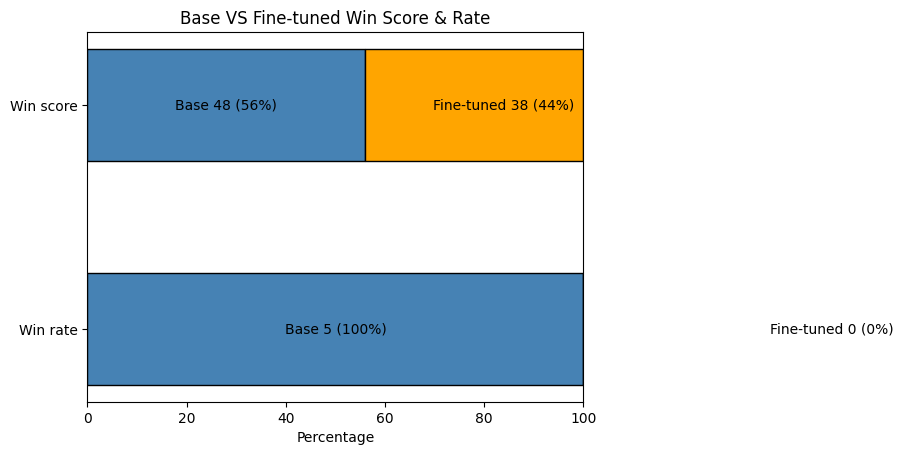

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data similar to the image
categories = ["Win rate", "Win score"]
win_rate_sum = win_results["A_wins"] + win_results["B_wins"]
win_score_sum = win_results["A_score"] + win_results["B_score"]

percentages1 = [round(win_results["A_wins"]*100/win_rate_sum), round(win_results["A_score"]*100/win_score_sum)]
percentages2 = [round(win_results["B_wins"]*100/win_rate_sum), round(win_results["B_score"]*100/win_score_sum)]
values1 = [win_results["A_wins"], win_results["A_score"]]
values2 = [win_results["B_wins"], win_results["B_score"]]

# Create a bar plot

# Bar positions
bar_width = 0.5
y_pos = range(len(categories))

# Plotting the bars
fig, ax = plt.subplots()

ax.barh(y_pos, percentages1, color='steelblue', edgecolor='black', height=bar_width)
ax.barh(y_pos, percentages2, left=percentages1, color='orange', edgecolor='black', height=bar_width)

# Adding text
for i in range(len(categories)):
    ax.text(percentages1[i]/2, i, f"Base {values1[i]} ({percentages1[i]}%)", ha='center', va='center', color='black')
    ax.text(percentages1[i] + percentages1[i]/2, i, f"Fine-tuned {values2[i]} ({percentages2[i]}%)", ha='center', va='center', color='black')

# Labels and Titles
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage')
ax.set_title('Base VS Fine-tuned Win Score & Rate')

plt.show()


## Exercise
1. Take Pre-training LLM course at Deeplearing.ai https://www.deeplearning.ai/short-courses/pretraining-llms/

2. Design and Make continuous fine-tuning systems.

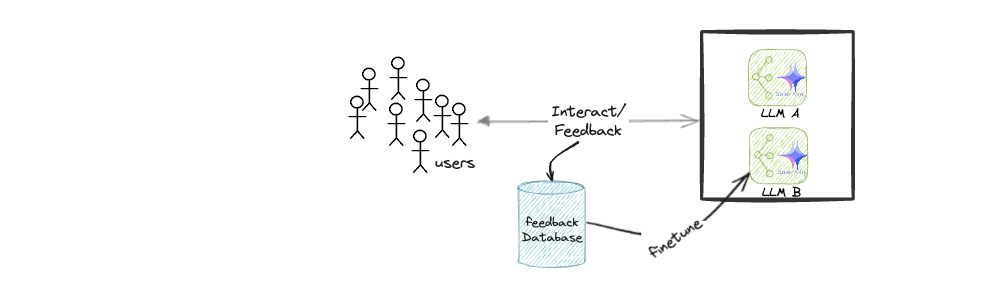